# **Jacob Shearer - Excercise set 4**

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import random

**Question 1:**

Part (a):
$$ \int_{20}^{500}c\cdot F(E) dE = c \cdot 4.14575\cdot10^{-6} = 1$$
<br/>
Therefore, to renormalize the distribution over the interval 20-500 MeV, we would need a normalization constant of $c = 4.14575\cdot10^{6}$.

In [2]:
def make_photons(num_photons):
    distribution = lambda E, a, k, E_c, c: c*k*E**(-a)*np.e**(-E/E_c)
    a = 1.87
    E_c = 81
    k = 1e-4
    c = 4.14575e6
    energies = np.array([])
    num_accepted = 0
    while num_accepted < num_photons:
        energy = random.uniform(20, 500)
        probability = distribution(energy, a, k, E_c, c)
        if probability > random.random():
            energies = np.append(energies, energy)
            num_accepted += 1
    
    return energies

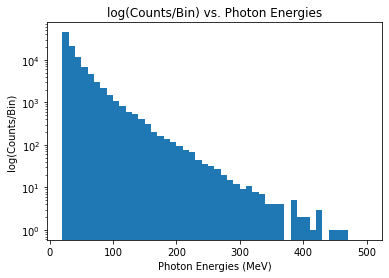

In [16]:
energies = make_photons(100000)
bin_stepsize = 10
energy_bins = np.arange(20, 500 + bin_stepsize, bin_stepsize)
plt.hist(energies, bins=energy_bins, log=True)
plt.title('log(Counts/Bin) vs. Photon Energies')
plt.xlabel('Photon Energies (MeV)')
plt.ylabel('log(Counts/Bin)')
plt.show()
# what is a log-log histogram? log bins? Ask about this...

Part (b):
<br/>
I'll use the following expressions to convert the rightward ascension and declination angles to x and y coordinates:
<br/>
$$ x = rcos(\delta)cos(\alpha)$$
$$ y = rcos(\delta)sin(\alpha)$$
<br/>
where $\alpha$ is the rightward ascention angle and $\delta$ is the declination angle. I'll also assume that the radial coordinate $r = 1$.

In [4]:
# Part (b):
def angles_to_x(r, RA, DEC):
    DEC = DEC * np.pi/180
    RA = RA * np.pi/180
    return r*np.cos(DEC)*np.cos(RA)

def angles_to_y(r, RA, DEC):
    DEC = DEC * np.pi/180
    RA = RA * np.pi/180
    return r*np.cos(DEC)*np.sin(RA)

def make_positions(energies, r, RA, DEC):
    distribution = lambda pos, sigma, energy, mue:(1/np.sqrt(2*np.pi*sigma**2))*np.e**(-((pos-mue)**2)/(2*mue**2))
    mue_x = angles_to_x(r, RA, DEC)
    mue_y = angles_to_y(r, RA, DEC)
    RA_array = np.array([])
    DEC_array = np.array([])
    for energy in energies:
        sigma = (energy/100)**-0.8
        while True:
            random_RA = random.uniform(0, 360)
            random_RA = 0 if random_RA == 360 else random_RA
            random_DEC = random.uniform(-90,90)
            random_x = angles_to_x(r, random_RA, random_DEC)
            random_y = angles_to_y(r, random_RA, random_DEC)
            x_prob = distribution(random_x, sigma, energy, mue_x)
            y_prob = distribution(random_y, sigma, energy, mue_y)
            if x_prob > random.random() and y_prob > random.random():
                RA_array = np.append(RA_array, random_RA)
                DEC_array = np.append(DEC_array, random_DEC)
                break
    
    return RA_array, DEC_array

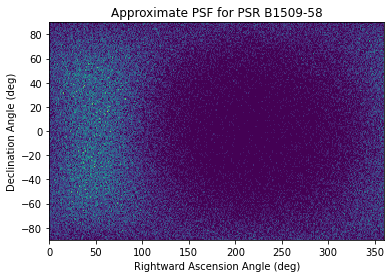

In [5]:
energies = np.zeros(100000) + 100
RA = 48.04
DEC = -30.92
RA_array, DEC_array = make_positions(energies, 1, RA, DEC)

%matplotlib inline
plt.hist2d(RA_array, DEC_array, bins=[np.arange(0, 361, 1), np.arange(-90, 91, 1)])
plt.xlabel('Rightward Ascension Angle (deg)')
plt.ylabel('Declination Angle (deg)')
plt.title('Approximate PSF for PSR B1509-58')
plt.show()

In [6]:
# Part (c):
RA = 48.04
DEC = -30.92
energies = make_photons(100000)
RA_array, DEC_array = make_positions(energies, 1, RA, DEC)

Part (c):


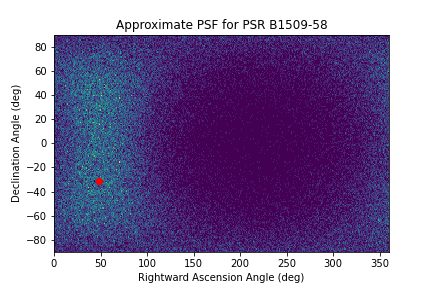

The red dot is the location of the pulsar.


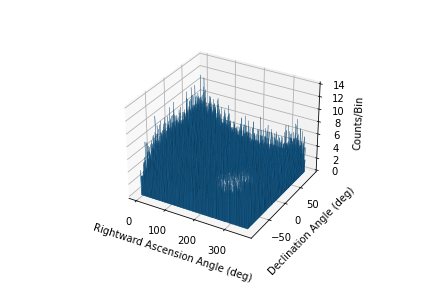

In [7]:
print('Part (c):')
%matplotlib widget
plt.hist2d(RA_array, DEC_array, bins=[np.arange(0, 361, 1), np.arange(-90, 91, 1)])
plt.scatter([RA], [DEC], c='r')
plt.xlabel('Rightward Ascension Angle (deg)')
plt.ylabel('Declination Angle (deg)')
plt.title('Approximate PSF for PSR B1509-58')
plt.show()
print('The red dot is the location of the pulsar.')
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
hist, x_edges, y_edges = np.histogram2d(RA_array, DEC_array, bins=[np.arange(0, 361, 1), np.arange(-90, 91, 1)])
xpos, ypos = np.meshgrid(x_edges[:-1] + 0.25, y_edges[:-1] + 0.25, indexing = 'ij')
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0
dx = dy = 0.5 * np.ones_like(zpos)
dz = hist.ravel()
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')
ax.set_xlabel('Rightward Ascension Angle (deg)')
ax.set_ylabel('Declination Angle (deg)')
ax.set_zlabel('Counts/Bin')
plt.show()

Part (d):
<br/>
The angles $\alpha_0 + a$, $\alpha_0 - a$, $\delta_0 +a$, and $\delta_0 -a$ define the maximum and minimum values of $\alpha$ and $\delta$ for a circle in the plane of the histogram. This circle is the "base" of a cone-like shape that is defined by the same angles in celestial coordinates, so if we can find a deviation angle $a$ such that the bins inside the circle contain >95% of the photons, then we can calculate the radius of the circle of interest with the following formula:
$$r_c = rtan(a)$$
<br/>
where $r$ is the radial coordinate to the pulsar. 

In [8]:
# Part (d):
print ('Part (d):')

# Hist is an array of 360 arrays, and each sub array contains the heights of the bins.
# Sub arrays start at -90 and go up to 90 (i.e. index 0 = -90, 180 = 90)
starting_RA = 48
starting_DEC = -38
num_photons = 100000
deviation_angle = 1

while True:
    photon_sum = 0
    max_RA = starting_RA + deviation_angle
    min_RA = starting_RA - deviation_angle
    max_DEC = starting_DEC + deviation_angle
    min_DEC = starting_DEC - deviation_angle
    # These domains define a box which encloses the circle
    RA_domain = np.arange(min_RA, max_RA+1, 1)
    DEC_domain = np.arange(min_DEC, max_DEC+1, 1)
    circle_radius_squared = (max_RA-starting_RA)**2 + starting_DEC**2
    for RA in RA_domain:
        for DEC in DEC_domain:
            radius_squared = (RA-starting_RA)**2 + (DEC-starting_DEC)**2
            # Checks to see if the specified coordinates are inside of the circle
            if radius_squared > circle_radius_squared:
                continue
            
            # Wraps the RA coordinate around on itself past 0 degrees or 360 degrees
            if RA < 0:
                RA_coord = RA + 360
            elif RA >= 360:
                RA_coord = RA_coord - 360
            else:
                RA_coord = RA
                
            RA_index = RA_coord - 1
            
            # Wraps the DEC coordinate around on itself past -90 degrees or 90 degrees
            if DEC < -90:
                DEC_coord = DEC + 180
            elif DEC > 90:
                DEC_coord = DEC -180
            else:
                DEC_coord = DEC
            
            DEC_index = DEC_coord + 90
            
            # Adds the photon count in that bin to the sum
            photon_sum += hist[RA_index][DEC_index]
    
    # Checks to see if the photon sum is greater than or equal to 95%
    sum_ratio = photon_sum/num_photons
    if sum_ratio >= 0.95:
        break

    deviation_angle += 1

print(f'For a deviation angle from the line to the pulsar of {deviation_angle} degrees:')
radius = np.tan(deviation_angle*(np.pi/180))
print(f'Radius = {np.abs(radius)}*r, where r is the distance to the pulsar')
# This is definitely wrong

Part (d):
For a deviation angle from the line to the pulsar of 106 degrees:
Radius = 3.48741444384091*r, where r is the distance to the pulsar


**Question 2:**

Part (a):


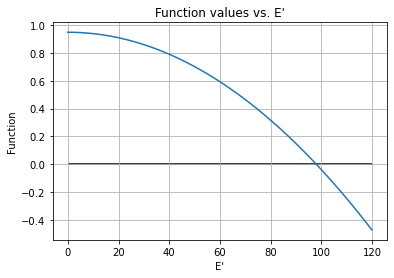

In [9]:
# Part (a):
print('Part (a):')

%matplotlib inline
E = 100
theta = 73 * np.pi/180
k = 2.5
E_0 = 511
E_prime = np.arange(0, 120, 0.1)
y = (E**2 - E_prime**2 + (k**2)*(1 + (2*E_0/k)))/(2*E*k*np.sqrt(1 + (2*E_0/k))) - np.cos(theta)
plt.plot(E_prime, y)
plt.title("Function values vs. E'")
plt.xlabel("E'")
plt.ylabel('Function')
plt.hlines(0,xmin=0,xmax=120, color='black', zorder=1)
plt.grid(True)
plt.show()


In [10]:
def newton_raphson(start_x, precision, function, maxiterations=100, printout=False):
    x = start_x
    df = 0
    previous_x = 0
    stepsize = 3e-1
    for i in range(0, maxiterations+1):
        F = function(x)
        if printout:
            string = f'Iteration {i+1}: x = {x}'
            message = string + f' (precision change = {np.abs(x - previous_x)})' if i > 0 else string
            print(message)
        
        if np.abs(F) <= precision:
            if printout:
                print(f'Root found at x = {x} with precision {precision}')
            
            break
        
        previous_x = x
        df = (function(x + stepsize) - function(x))/stepsize
        stepsize = -F/df
        x += stepsize
        
    return x
        
def electron_scattering(E_prime):
    scattering_function = lambda E, E_prime, k, E_0, theta: (E**2 - E_prime**2 + (k**2)*(1 + (2*E_0/k)))/(
        2*E*k*np.sqrt(1 + (2*E_0/k))) - np.cos(theta)
    E = 100
    theta = 73 * np.pi/180
    k = 2.5
    E_0 = 511
    return scattering_function(E, E_prime, k, E_0, theta)

In [11]:
numerical_energy = newton_raphson(95, 0.00001, electron_scattering, printout=True)

Iteration 1: x = 95
Iteration 2: x = 98.03170857730204 (precision change = 3.031708577302041)
Iteration 3: x = 97.9901116557599 (precision change = 0.04159692154213701)
Iteration 4: x = 97.9894592063166 (precision change = 0.0006524494433080008)
Root found at x = 97.9894592063166 with precision 1e-05


Part (b):
<br/>
Solving the function for $E'$, we get:
$$E' = \sqrt{E^2 + k^2(1+ \frac{2E_0}{k}) - 2EK\sqrt{1 + \frac{2E_0}{k}}cos\theta}$$

In [12]:
calculated_energy = np.sqrt(E**2 + (k**2)*(1+(2*E_0/k)) -(np.cos(theta)*(2*E*k*np.sqrt(1+(2*E_0/k)))))
print(f'The analytically calculated scattering energy is {calculated_energy} keV')
print(f'''This only differs from the numerical result from part (a) by {np.abs(calculated_energy-numerical_energy)} keV,
so it's easily within the precision of the numerical result.''')

The analytically calculated scattering energy is 97.98945934262818 keV
This only differs from the numerical result from part (a) by 1.3631158424232126e-07 keV,
so it's easily within the precision of the numerical result.


Part (c):


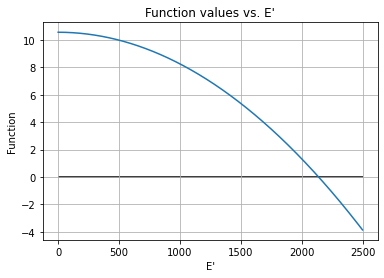

Iteration 1: x = 2200
Iteration 2: x = 2139.406801383335 (precision change = 60.59319861666518)
Iteration 3: x = 2138.5320927799835 (precision change = 0.8747086033513369)
Iteration 4: x = 2138.544308393271 (precision change = 0.012215613287480664)
Root found at x = 2138.544308393271 with precision 1e-05


In [13]:
# Part (c):
print('Part (c):')

def proton_scattering(E_prime):
    scattering_function = lambda E, E_prime, k, E_0, theta: (E**2 - E_prime**2 + (k**2)*(1 + (2*E_0/k)))/(
        2*E*k*np.sqrt(1 + (2*E_0/k))) - np.cos(theta)
    E = 100
    theta = 73 * np.pi/180
    k = 2.5
    E_0 = 938000
    return scattering_function(E, E_prime, k, E_0, theta)

E_prime = np.arange(0, 2500, 0.1)
y = proton_scattering(E_prime)
plt.plot(E_prime, y)
plt.title("Function values vs. E'")
plt.xlabel("E'")
plt.ylabel('Function')
plt.hlines(0,xmin=0,xmax=2500, color='black', zorder=1)
plt.grid(True)
plt.show()

p_numerical_energy = newton_raphson(2200, 0.00001, proton_scattering, printout=True)
# E_0 = 938000
# p_calculated_energy = np.sqrt(E**2 + (k**2)*(1+(2*E_0/k)) -(np.cos(theta)*(2*E*k*np.sqrt(1+(2*E_0/k)))))

According to this calculation, an electron with 100 keV of kinetic energy that scatters at an angle of 73$^\circ$ with a proton would end up with a scattered energy of over 2138 keV, which makes no sense because that's much larger than the 100 keV that the electron started with (conservation of energy violation). What this probably means is that an electron with that starting energy wouldn't compton scatter with a proton at that particular angle.

**Question 3:**